# Download REMA data
This will use code written by Julian Spergel to download the REMA data. The first method is the most useful one (so far), it downloads REMA tiles for a given ice shelf.  

It will draw heavily from here: https://github.com/ldeo-glaciology/REMAWaterRouting/blob/master/dask_drainagecatchmentmapping.ipynb

In [1]:
import json
import os
import gcsfs
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget

import geopandas as gpd
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
import math
import shapefile
import shapely
import pandas as pd
import rioxarray

/var/folders/kl/3mt9f4qs1559xwy3mr60s7980000gp/T/ipykernel_25862/2911127816.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Method 1: Load REMA tiles using Julian's code 

<Axes: >

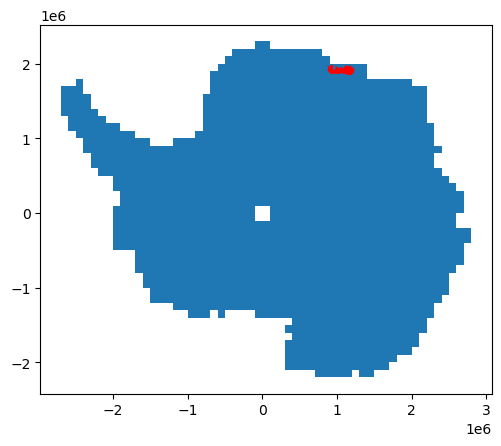

In [2]:
#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('../../../REMAWaterRouting/IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 

#select an ice shelf, e.g. 'Amery' or 'Baudouin' ()
Baudouin = IS[IS.NAME=='Baudouin']

#read in the REMA tile index
REMA_index = gpd.read_file('../../../REMAWaterRouting/REMA_Tile_Index/REMA_Tile_Index_Rel1_1.shp')

fig,axis = plt.subplots()
REMA_index.plot(ax=axis)
Baudouin.geometry.plot(ax=axis,color='r')

In [3]:
# find what tiles the ice shelf intersects

[minx,miny,maxx,maxy]= Baudouin.bounds.values.tolist()[0]
#[minx,miny,maxx,maxy]= DarwinGlacier.bounds

bbox = shapely.geometry.Polygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])

IS_intersection = np.argwhere(REMA_index.overlaps(bbox).tolist())

IS_tiles = REMA_index.tile[IS_intersection.flatten()]
IS_tiles

280     49_40
622     50_39
1010    49_43
1043    50_40
1095    49_39
1167    50_41
1255    49_42
1288    50_42
1315    49_41
1423    50_43
Name: tile, dtype: object

In [4]:
#extract the row and column numbers of the REMA tiles from the subsetted list of tiles, IS_tiles

row = [str.split(x,'_')[0] for x in IS_tiles.to_list()]
col = [str.split(x,'_')[1] for x in IS_tiles.to_list()]
row = np.int_(row)
col = np.int_(col)


In [5]:
#Load the REMA tiles lazily
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(np.arange(row.max(), row.min()-1, -1)): 
    cols = []
    for j in np.arange(col.min(),col.max()+1):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            print(uri)
            dset = rioxarray.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            print(f'failed to load tile {i},{j}')
            pass
    rows.append(cols)

  0%|          | 0/2 [00:00<?, ?it/s]

https://storage.googleapis.com/pangeo-pgc/8m/50_39/50_39_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/50_40/50_40_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/50_41/50_41_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/50_42/50_42_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/50_43/50_43_8m_dem_COG_LZW.tif


Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
ERROR 1: /vsicurl/https://storage.googleapis.com/pangeo-pgc/8m/50_43/50_43_8m_dem_COG_LZW.tif:Failed to allocate memory for to read TIFF directory (0 elements of 12 bytes each)
ERROR 1: TIFFReadDirectory:Failed to read directory at offset 30222


https://storage.googleapis.com/pangeo-pgc/8m/49_39/49_39_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/49_40/49_40_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/49_41/49_41_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/49_42/49_42_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/49_43/49_43_8m_dem_COG_LZW.tif


In [6]:
dset = rioxarray.open_rasterio("https://storage.googleapis.com/pangeo-pgc/8m/50_39/50_39_8m_dem_COG_LZW.tif")

In [7]:
dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )

In [8]:
ds = ds.squeeze()
ds

<xarray.DataArray (y: 25000, x: 62500)>
dask.array<getitem, shape=(25000, 62500), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 8e+05 8e+05 8e+05 8e+05 ... 1.3e+06 1.3e+06 1.3e+06
  * y            (y) float64 2e+06 2e+06 2e+06 2e+06 ... 1.8e+06 1.8e+06 1.8e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    _FillValue:          -9999.0
    scale_factor:        1.0
    add_offset:          0.0

Make a small geotiff consisting of just on chunk of the Boudouin dataset loaded above: 

In [17]:
# subset the data
dem_small_1 = ds.isel(x=slice(0,4095), y=slice(0,4095)).load()
# add some zeros that we will use as ocean cells later
dem_small_1[0:1,:] = 0.0 
# make a new directory for the small DEMs (if needed)
#!mkdir rema_subsets
# write the subsetted DEM to a GeoTiff
dem_small_1.rio.to_raster("rema_subsets/dem_small_1.tif")
# reload the DEM from disk
reloaded = rioxarray.open_rasterio("rema_subsets/dem_small_1.tif")
# squeeze the reloaded data
reloaded = reloaded.squeeze()
#check that the reloaded data is identical to the original
dem_small_1.identical(reloaded)


True

In [23]:
# subset the data
dem_small_2 = ds.isel(x=slice(0,4095,4), y=slice(0,4095*3,4)).load()
# add some zeros that we will use as ocean cells later
dem_small_2[0:1,:] = 0.0 
# make a new directory for the small DEMs (if needed)
#!mkdir rema_subsets
# write the subsetted DEM to a GeoTiff
dem_small_2.rio.to_raster("rema_subsets/dem_small_2.tif")
# reload the DEM from disk
reloaded = rioxarray.open_rasterio("rema_subsets/dem_small_2.tif")
# squeeze the reloaded data
reloaded = reloaded.squeeze()
#check that the reloaded data is identical to the original
dem_small_2.identical(reloaded)   # not sure what these are not the same, the values lookthe same



False

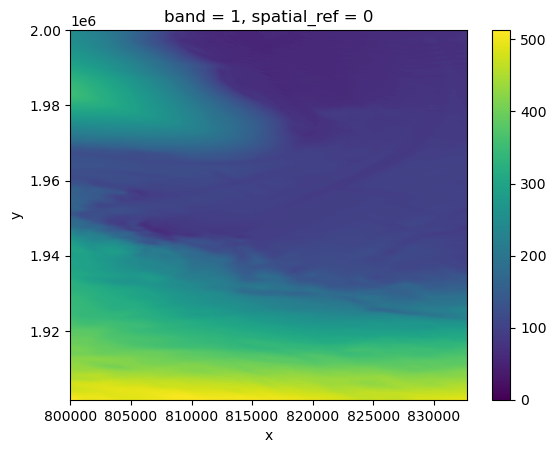

In [24]:
dem_small_2.plot()

In [48]:
reloaded.values[np.where((reloaded !=  dem_small_2).values)][0]

nan

In [49]:
dem_small_2.values[np.where((reloaded !=  dem_small_2).values)][0]


nan

In [50]:
dem_small_2

<xarray.DataArray (y: 3072, x: 1024)>
array([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [241.14444 , 241.08432 , 241.00006 , ...,  71.77741 ,  71.97595 ,
         72.10481 ],
       [241.29431 , 241.28967 , 241.20699 , ...,  71.889305,  72.16418 ,
         72.22068 ],
       ...,
       [512.6128  , 512.3172  , 512.0447  , ..., 492.42545 , 492.57556 ,
        492.662   ],
       [512.64026 , 512.4237  , 512.1342  , ..., 492.64294 , 492.73138 ,
        492.83432 ],
       [512.8277  , 512.67645 , 512.3371  , ..., 492.9914  , 493.01517 ,
        492.95914 ]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 8e+05 8e+05 8.001e+05 ... 8.327e+05 8.327e+05
  * y            (y) float64 2e+06 2e+06 2e+06 ... 1.902e+06 1.902e+06 1.902e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    _FillValue:          -9999.0
    scale_factor:        1.0
    add_offset:          0.0

## Method 2: try downloading the processed data
Julian put 'processed' data in the google bucket. But this appearrs to just be the computed drainage basins, not the desriped DEMs. The cell below load these. One other issue is that the processed data is rotated 90 degrees from the original data. 

In [ ]:
ice_shelf = 'Amery'
with open('/Users/jkingslake/Documents/misc/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)
mapper = gcs.get_mapper(str('gs://ldeo-glaciology/REMA/processed/'+ice_shelf))


In [ ]:
processed = xr.open_zarr(mapper, consolidated=False)

In [ ]:
processed

<xarray.Dataset>
Dimensions:      (y: 18750, x: 6250)
Coordinates:
  * x            (x) float64 8e+05 8e+05 7.999e+05 ... 6.001e+05 6e+05 6e+05
  * y            (y) float64 1.6e+06 1.6e+06 1.6e+06 ... 2.2e+06 2.2e+06 2.2e+06
Data variables:
    DB_filled    (y, x) float64 dask.array<chunksize=(586, 391), meta=np.ndarray>
    DB_unfilled  (y, x) float64 dask.array<chunksize=(586, 391), meta=np.ndarray>
    P_all        (y, x) float64 dask.array<chunksize=(586, 391), meta=np.ndarray>

In [ ]:
(processed.x[1]-processed.x[0]).values, (processed.y[1]-processed.y[0]).values

(array(-32.), array(32.))

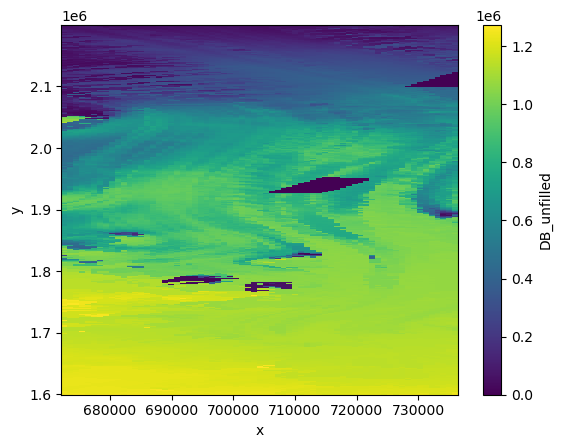

In [ ]:
# plot a low resolutio nsubset of the unfilled drainage basins
processed.isel(x=slice(2000,4000,30),y=slice(0,None,30)).DB_unfilled.plot() 

6.008


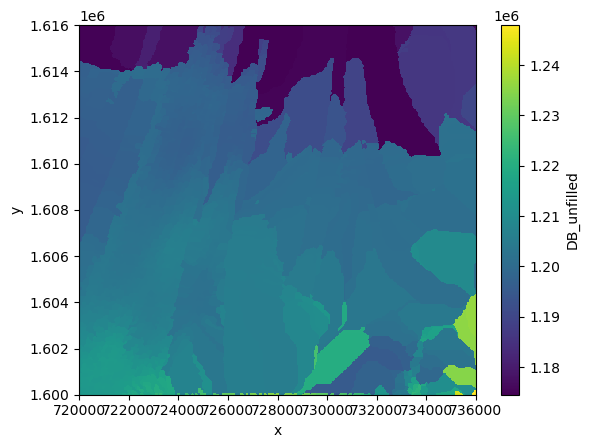

In [ ]:
# plot just an much smaller subset at the full resolution
s = processed.isel(x=slice(2000,2500),y=slice(0,500))
print(s.nbytes/1e6)
s.DB_unfilled.plot()
